# Análisis de resultados y telemetría de Formula 1

El siguiente código tiene como objetivo el análisis de los datos de tiempos proporcionados por la Formula 1 para la realización de estrategias y comparativas de rendimiento entre vueltas y pilotos. Para su creación, se ha usado el paquete de Python FastF1, la librería de gráficos Matplotlib, y Numpy. Se presentan tres análisis diferentes:
- **Primer análisis**: comparación de telemetría de las vueltas rápidas de dos pilotos.
- **Segundo análisis**: comparación del ritmo de carrera entre dos pilotos.
- **Tercer análisis**: obtención de las vueltas más rápidas (de todos o solo un piloto) de una sesión y su tiempo por sectores, comparado con la vuelta ideal.

***

In [53]:
#Importación de las librerías necesarias
import fastf1 as ff1
import fastf1.plotting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

#Configuración de matplotlib con FastF1
fastf1.plotting.setup_mpl()

#Configuración de directorio como caché
ff1.Cache.enable_cache('cache')

#Función para obtener el tiempo de vuelta formateado en minutos:segundos.milisegundos
def format_timedelta(timedelta, include_minutes=True):
    minutes = timedelta.seconds//60
    seconds = timedelta.seconds%60
    miliseconds = int(timedelta.microseconds//1000)
    if include_minutes:
        return f"{minutes}:{seconds}.{miliseconds:03d}"
    else:
        return f"{seconds}.{miliseconds:03d}"

#Obtener la posición (en metros) de los finales de sectores a través de la telemetría  
def get_sectors_distance(flap):
    flap_tel = flap.get_telemetry()
    sectors = [flap["Sector1Time"], flap["Sector2Time"], flap["Sector3Time"]]
    sectors_cum = np.cumsum(sectors)
    flap_tel.sort_values(by="Distance", inplace=True, ascending=False)
    sector_dist = []
    flap_tel
    for sector in sectors_cum:
        sector_dist.append(flap_tel[flap_tel["Time"] <= sector].iloc[0]["Distance"])
    return sector_dist

#Obtener la posición (en metros) de los inicios y finales de DRS a través de la telemetría
def get_drs_zones(flap):
    flap_tel = flap.get_telemetry()
    drs_zones_activation = []
    drs_zones_deactivation = []
    for i in range(0, len(flap_tel)-1):
        if flap_tel.iloc[i]["DRS"] < 10 and flap_tel.iloc[i+1]["DRS"] >= 10:
            drs_zones_activation.append(flap_tel.iloc[i]["Distance"])

        if flap_tel.iloc[i]["DRS"] >= 10 and flap_tel.iloc[i+1]["DRS"] < 10:
            drs_zones_deactivation.append(flap_tel.iloc[i]["Distance"])

    if len(drs_zones_activation) == 3:
        return np.array([[0, drs_zones_deactivation[0]], [drs_zones_activation[0], drs_zones_deactivation[1]], [drs_zones_activation[1], drs_zones_deactivation[2]], [drs_zones_activation[2], flap_tel.iloc[-1]["Distance"]]])
    else:
        return []

***


## Primer análisis: telemetría de las mejores vueltas de dos pilotos en una sesión

Este análisis tiene como objetivo comparar los datos de telemetría aportados por los coches, comparando la mejor vuelta de dos pilotos en una misma sesión. Suele ser de mucha utilidad en las sesiones de calificación, ya que es aquí donde el entorno es más similar entre las dos vueltas y donde el piloto intenta obtener el mayor rendimiento del monoplaza. Como resultado se obtiene una figura con 4 *subplots* en su interior:
1. El primer gráfico muestra en su eje izquierdo la velocidad de los monoplazas a través del trazado, mientras que en el eje derecho se muestra la diferencia de velocidad entre el piloto más rápido y el otro piloto seleccionado. También se muestra el punto donde finaliza cada sector. Si ambos pilotos abrieron el DRS, también se mostrará la zona de DRS sombreada en amarillo.
2. El segundo gráfico muestra tanto la marcha a la que pilotan en cada zona del circuito, como las revoluciones por minuto del motor.
3. El tercer gráfico muestra el nivel de aceleración.
4. El cuarto gráfico muestra los momentos de frenada (dato binario, F1 solo publica si se estaba presionando el freno, pero no el nivel).

Usando el valor asignado a las variables `driver1` y `driver2` podemos elegir los pilotos a comparar, mientras que usando las variables `gp` y `sesion` podemos elegir la fuente de los datos. Esto será así para los tres análisis. Los valores posibles de la sesión pueden ser `FP1`, `FP2`, `FP3`, `Q`, `R`.  

Este análisis lo podemos usar, por ejemplo, para observar las velocidades de entrada y salida de cada uno de los pilotos de los diferentes trazados del circuito. También podemos observar el rendimiento del monoplaza y la reducción de *drag* cuando los pilotos abren del DRS (*Drag Reduction System*). Otra información a comparar importante es el punto de frenada de cada uno de los pilotos. En general, es una figura muy completa para analizar la vuelta más rápida y donde se pierde rendimiento. Para realizarlo, primero se han obtenido las vueltas rápidas de los pilotos dentro de una misma sesión. Después se ha obtenido la telemetría de dichas vueltas. Los datos de telemetría ya estaban incluidos; sin embargo, datos como la distancia, las zonas de los sectores o las zonas de DRS deben obtenerse de los valores asociados a la telemetría.

In [54]:
#Primer análisis: análisis telemetría de la vuelta más rápida de dos pilotos

#Selección de los pilotos
driver1 = "ALO"
driver2 = "PER"

#Selección de la carrera y sesión
gp = "Miami"
session = "Q"

#Selección de la sesión
sesion = ff1.get_session(2023, gp, session)

#Carga de los datos de la sesión
sesion.load()

#Orden de los pilotos por posición
results = sesion.results
driver1_pos = results[results["Abbreviation"] == driver1]["Position"]
driver2_pos = results[results["Abbreviation"] == driver2]["Position"]

#Reorden de los pilotos para que el primero sea el que va el que tenga la vuelta más rápida
if driver1_pos.values[0] > driver2_pos.values[0]:
    ahead = driver2
    driver2 = driver1
    driver1 = ahead

core           INFO 	Loading data for Miami Grand Prix - Qualifying [v3.0.0]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '14', '55', '20', '10', '63', '16', '31', '1', '77', '23', '27', '44', '24', '21', '4', '22', '18', '81', '2']


/home/jesusjover/.local/lib/python3.8/site-packages/fastf1/utils.py:81: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


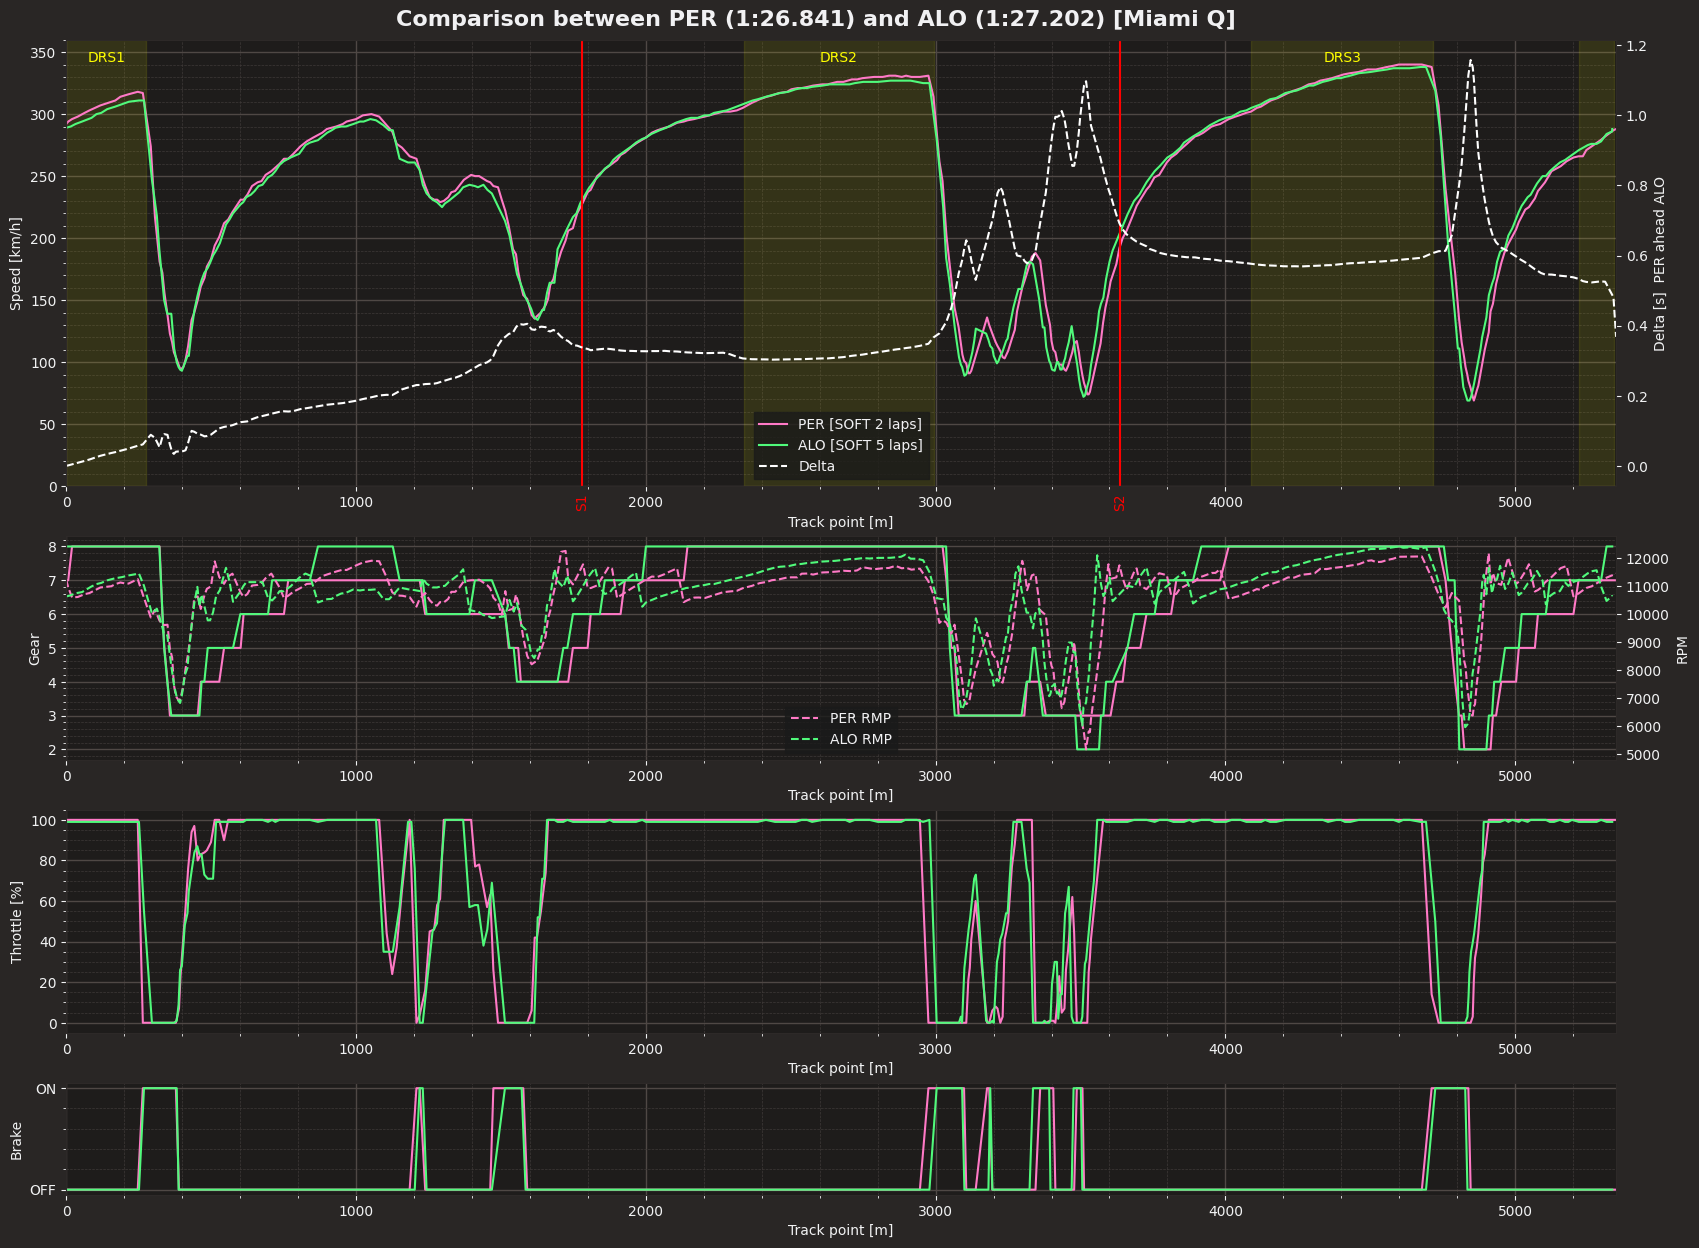

In [55]:
#Selección de la vuelta rápida de cada piloto
driver1_fastlap = sesion.laps.pick_driver(driver1).pick_fastest()
driver2_fastlap = sesion.laps.pick_driver(driver2).pick_fastest()
driver1_fastlap_tel = driver1_fastlap.get_car_data()
driver2_fastlap_tel = driver2_fastlap.get_car_data()

#Obtención de la posición de los sectores
sector_dist_1 = np.array(get_sectors_distance(driver1_fastlap))
sector_dist_2 = np.array(get_sectors_distance(driver2_fastlap))
sector_dist = (sector_dist_1 + sector_dist_2)/2
max_dist = max(max(sector_dist_1), max(sector_dist_2))

#Obtención del inicio y fin del DRS
drs_zones_1 = get_drs_zones(driver1_fastlap)
drs_zones_2 = get_drs_zones(driver2_fastlap)
if len(drs_zones_1) != 0 or len(drs_zones_2) != 0:
    drs_zones = (drs_zones_1 + drs_zones_2)/2

#Obtención del delta entre pilotos
delta, delta_ref, delta_comp = ff1.utils.delta_time(driver1_fastlap,driver2_fastlap)

#Figura y configuración
fig, ax = plt.subplots(4, gridspec_kw={"height_ratios": [4, 2, 2, 1]})
fig.set_size_inches(20, 15)
fig.suptitle(f"Comparison between {driver1} ({format_timedelta(driver1_fastlap['LapTime'])}) and {driver2} ({format_timedelta(driver2_fastlap['LapTime'])}) [{gp} {session}]", fontsize=16, fontweight="bold", y=0.90)

#Plot de velocidad
ax[0].plot(delta_ref["Distance"], delta_ref["Speed"], label=f'{driver1} [{driver1_fastlap["Compound"]} {int(driver1_fastlap["TyreLife"])} laps]')
ax[0].plot(delta_comp["Distance"], delta_comp["Speed"], label=f'{driver2} [{driver2_fastlap["Compound"]} {int(driver2_fastlap["TyreLife"])} laps]')
ax[0].plot(0,0, label="Delta", color="white", linestyle="--")
ax[0].set_xlabel("Track point [m]")
ax[0].set_ylabel("Speed [km/h]")
ax[0].legend(loc="lower center")
ax[0].set_xlim([0, max_dist])
ax[0].set_ylim([0, 360])

#Plot de delta de tiempo
twin = ax[0].twinx()
twin.plot(delta_ref["Distance"], delta, color="white", linestyle="--", label="Delta")
twin.set_ylabel(f"Delta [s]  {driver1} ahead {driver2}")

#Sectores
for sector in sector_dist[0:2]:
    ax[0].axvline(x=sector, color="red", linestyle="-")
    #Nombre del vector
    ax[0].text(sector, -20, f"S{np.where(sector_dist == sector)[0][0]+1}", rotation=90, verticalalignment="bottom", horizontalalignment="center", color="red")

#Zonas de DRS
if len(drs_zones_1) != 0 or len(drs_zones_2) != 0:
    for drs_zone in drs_zones:
        ax[0].axvspan(drs_zone[0], drs_zone[1], alpha=0.1, color="yellow")
    for drs_zone in drs_zones[0:3]:
        ax[0].text((drs_zone[0]+drs_zone[1])/2, 340, f"DRS{np.where(drs_zones == drs_zone)[0][0]+1}", rotation=0, verticalalignment="bottom", horizontalalignment="center", color="yellow")

#Plot de marcha
ax[1].plot(delta_ref["Distance"], delta_ref["nGear"], label=f"{driver1}")
ax[1].plot(delta_comp["Distance"], delta_comp["nGear"], label=f"{driver2}")
ax[1].set_xlabel("Track point [m]")
ax[1].set_ylabel("Gear")
ax[1].set_xlim([0, max_dist])

#Plot de RPM
twin = ax[1].twinx()
twin.plot(delta_ref["Distance"], delta_ref["RPM"], linestyle="--", label=f"{driver1} RMP")
twin.plot(delta_comp["Distance"], delta_comp["RPM"], linestyle="--", label=f"{driver2} RMP")
twin.set_ylabel("RPM")
twin.legend(loc="lower center")

#Plot de nivel de acelerador
ax[2].plot(delta_ref["Distance"], delta_ref["Throttle"], label=f"{driver1}")
ax[2].plot(delta_comp["Distance"], delta_comp["Throttle"], label=f"{driver2}")
ax[2].set_xlabel("Track point [m]")
ax[2].set_ylabel("Throttle [%]")
ax[2].set_xlim([0, max_dist])

#Plot de frenada
ax[3].plot(delta_ref["Distance"], delta_ref["Brake"], label=f"{driver1}")
ax[3].plot(delta_comp["Distance"], delta_comp["Brake"], label=f"{driver2}")
ax[3].set_xlabel("Track point [m]")
ax[3].set_ylabel("Brake")
ax[3].set_xlim([0, max_dist])
ax[3].set_yticks([0, 1])
ax[3].set_yticklabels(["OFF", "ON"])

#Almacenamiento de la imagen
plt.savefig("first_analysis.png", dpi=150, bbox_inches="tight")

***


## Segundo análisis: comparación de ritmo de carrera entre dos pilotos

Este análisis tiene como objetivo comparar el ritmo de carrera entre dos pilotos. Se observa en el eje X cada una de las vueltas de un gran premio, mientras en el eje Y observaremos:
- En el eje izquierdo el tiempo de vuelta, expresado en minutos:segundos.milisegundos.
- En el eje derecho el *gap* entre un piloto y otro.

Usando el valor asignado a las variables `driver1` y `driver2` podemos elegir los pilotos a comparar, mientras que usando las variables `gp` y `sesion` podemos elegir la fuente de los datos. Esto será así para los tres análisis. Los valores posibles de la sesión pueden ser `FP1`, `FP2`, `FP3`, `Q`, `R`.  

Este análisis lo podemos usar, por ejemplo, para comparar el ritmo en tanda larga de los pilotos y los monoplazas. 

In [56]:
#Segundo análisis: comparación de ritmo de carrera entre dos pilotos
gp = 'Miami'
session = 'R'

#Selección de la sesión
race_data = ff1.get_session(2023, gp, session)
#Carga de los datos de la sesión
race_data.load()


core           INFO 	Loading data for Miami Grand Prix - Race [v3.0.0]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']


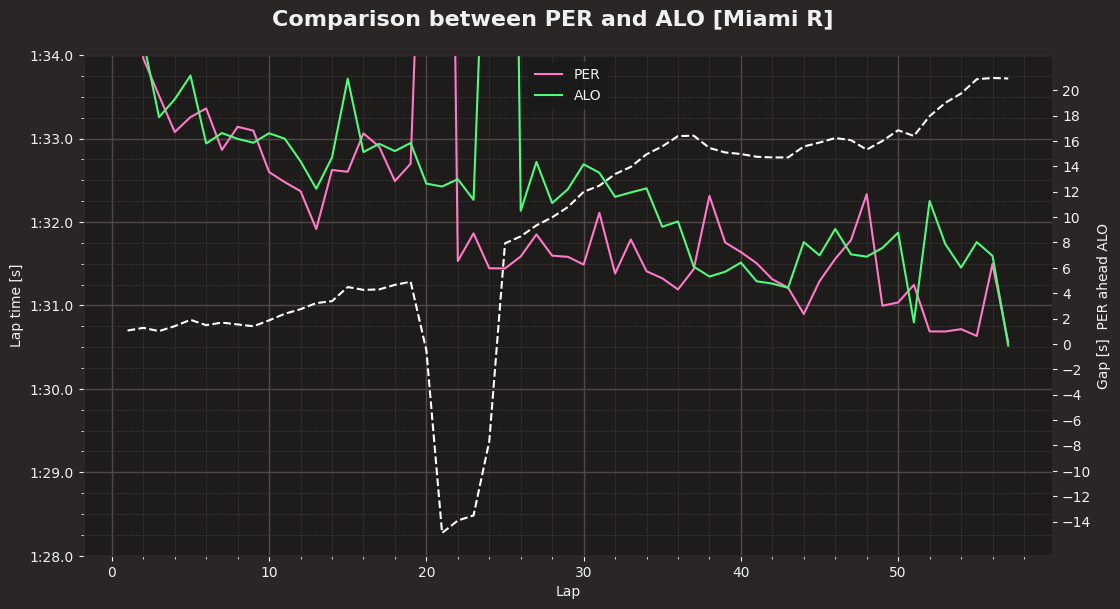

In [57]:
driver1 = 'PER'
driver2 = 'ALO'

#Orden de los pilotos por posición
results = race_data.results
driver1_pos = results[results["Abbreviation"] == driver1]["ClassifiedPosition"]
driver2_pos = results[results["Abbreviation"] == driver2]["ClassifiedPosition"]

if driver1_pos.values[0] > driver2_pos.values[0]:
    ahead = driver2
    driver2 = driver1
    driver1 = ahead

driver1_laps = race_data.laps.pick_driver(driver1).reset_index()
#driver1_laps["CumulativeTime"] = driver1_laps["LapTime"].cumsum();
driver2_laps = race_data.laps.pick_driver(driver2).reset_index()
#driver2_laps["CumulativeTime"] = driver2_laps["LapTime"].cumsum();

t_init = datetime.strptime("1:28","%M:%S")
t_last = datetime.strptime("1:34","%M:%S")
t_init = timedelta(minutes=t_init.minute, seconds=t_init.second)
t_last = timedelta(minutes=t_last.minute, seconds=t_last.second)
fig, ax = plt.subplots(1)
fig.set_size_inches(12.5, 6.5)

#Plot de ritmo de carrera
plt.suptitle(f"Comparison between {driver1} and {driver2} [{gp} {session}]", fontsize=16, fontweight="bold", y=0.95)
ax.plot(range(1, race_data.total_laps+1), driver1_laps["LapTime"], label=f"{driver1}")
ax.plot(range(1, race_data.total_laps+1), driver2_laps["LapTime"], label=f"{driver2}")
ax.set_xlabel("Lap")
ax.set_ylabel("Lap time [s]")
ax.legend(loc="upper center")
ax.set_ylim([t_init, t_last])

#Plot de delta de tiempo
twin = ax.twinx()
delta = (driver2_laps["LapStartTime"]+driver2_laps["LapTime"]) - (driver1_laps["LapStartTime"] + driver1_laps["LapTime"])
delta = delta.apply(lambda x: x.total_seconds()).astype(float)
twin.plot(range(1, race_data.total_laps+1), delta, color="white", linestyle="--", label="Delta")
step = round((delta.max()-delta.min())/15)
if step == 0:
    step = 1
twin.set_yticks(np.arange(int(delta.min()), int(delta.max())+1, step))
twin.set_ylabel(f"Gap [s]  {driver1} ahead {driver2}")

#Almacenamiento de la imagen
plt.savefig("second_analysis.png", dpi=150, bbox_inches="tight")

***


## Tercer análisis: telemetría de las mejores vueltas de dos pilotos en una sesión

Este análisis tiene como objetivo comparar los datos de las mejores X vueltas de una sesión, y comparar el tiempo perdido en cada uno de los sectores en comparación con la vuelta ideal (aquella que se conforma con la suma del mejor tiempo marcado en cada uno de los sectores.)

Usando el valor asignado a las variables `driver1` podemos elegir el piloto a comparar, mientras que si su valor es `""` buscará las X mejores vueltas de todos los pilotos. Usando las variables `gp` y `sesion` podemos elegir la fuente de los datos. Esto será así para los tres análisis. Los valores posibles de la sesión pueden ser `FP1`, `FP2`, `FP3`, `Q`, `R`.  

Este análisis lo podemos usar, por ejemplo, en qué sectores los pilotos y los monoplazas tienen una mayor perdida de tiempo, así como representar virtualmente cómo de lejos están de la vuelta ideal.

In [61]:
# Tercer análisis: ritmo medio de las X mejores vueltas

#Selección de GP y la sesión
gp = 'Miami'
session = 'R'

#Carga de los datos de la sesión
sesion = ff1.get_session(2023, gp, session)
sesion.load()

core           INFO 	Loading data for Miami Grand Prix - Race [v3.0.0]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']


/tmp/ipykernel_6795/384548166.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  driver1_laps = driver1_laps.append(ideal_lap, ignore_index=True)
/tmp/ipykernel_6795/384548166.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver1_laps["LapLabel"].iloc[-1] = f"Ideal Lap \n {format_timedelta(ideal_lap['LapTime'])}" + (f'\n (for {driver1})' if driver1 != '' else '')


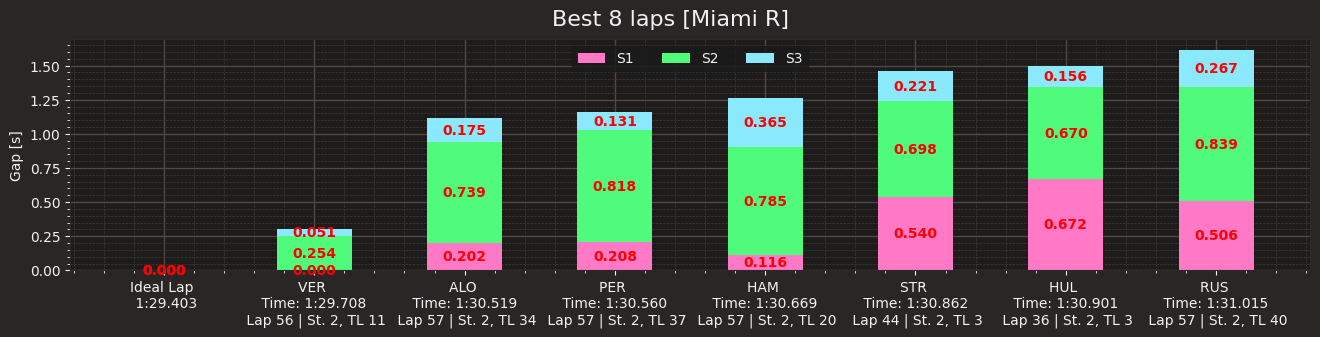

In [62]:
#Selección del número de vueltas
driver1 = ""   #Si el valor es "", se obtendrán datos de todos los pilotos
bestlaps = 8

#Selección de las vueltas del piloto
if driver1 == "":
    driver1_laps = sesion.laps
else:
    driver1_laps = sesion.laps.pick_driver(driver1).reset_index()

driver1_laps["Sector1Time"] = driver1_laps["Sector1Time"].apply(lambda x: x.total_seconds()).astype(float)
driver1_laps["Sector2Time"] = driver1_laps["Sector2Time"].apply(lambda x: x.total_seconds()).astype(float)
driver1_laps["Sector3Time"] = driver1_laps["Sector3Time"].apply(lambda x: x.total_seconds()).astype(float)
#driver1_laps["LapTime"] = driver1_laps["LapTime"].apply(lambda x: x.total_seconds()).astype(float)
driver1_laps.iloc[-1]
#Compute ideal lap
ideal_lap = driver1_laps.iloc[0].copy()
ideal_lap["Driver"] = ""
ideal_lap["LapNumber"] = 0
ideal_lap["Sector1Time"] = driver1_laps["Sector1Time"].min()
ideal_lap["Sector2Time"] = driver1_laps["Sector2Time"].min()
ideal_lap["Sector3Time"] = driver1_laps["Sector3Time"].min()
ideal_lap["LapTime"] = timedelta(seconds=ideal_lap["Sector1Time"] + ideal_lap["Sector2Time"] + ideal_lap["Sector3Time"])
#Create timedelta object based on seconds

driver1_laps = driver1_laps.append(ideal_lap, ignore_index=True)
ideal_lap = driver1_laps.iloc[-1]
driver1_laps = driver1_laps[driver1_laps["LapTime"].notna()]

#Compute delta
driver1_laps["DeltaSector1"] = driver1_laps["Sector1Time"] - ideal_lap["Sector1Time"]
driver1_laps["DeltaSector2"] = driver1_laps["Sector2Time"] - ideal_lap["Sector2Time"]
driver1_laps["DeltaSector3"] = driver1_laps["Sector3Time"] - ideal_lap["Sector3Time"]
driver1_laps["LapLabel"] = driver1_laps.apply(lambda x: f'{x["Driver"]} \n Time: {format_timedelta(x["LapTime"])} \n Lap {int(x["LapNumber"])} | St. {int(x["Stint"])}, TL {int(x["TyreLife"])}', axis=1)
driver1_laps["LapLabel"].iloc[-1] = f"Ideal Lap \n {format_timedelta(ideal_lap['LapTime'])}" + (f'\n (for {driver1})' if driver1 != '' else '')

driver1_laps = driver1_laps.sort_values(by="LapTime", ascending=True)
#Take best lap of every driver
if driver1 == "":
    driver1_laps = driver1_laps.groupby("Driver").head(1)
#driver1_laps = driver1_laps[driver1_laps["IsAccurate"] == True]

#Selección de las X mejores vueltas
driver1_laps = driver1_laps.head(bestlaps)
#ideal_lap["LapsLabel"] = "Ideal Lap"

fig, ax = plt.subplots(1)
fig.set_size_inches(bestlaps*2,3, 15)
fig.suptitle(f"Best {bestlaps} laps [{gp} {session}]", fontsize=16)

sectors_times = {
    "S1": driver1_laps["DeltaSector1"].values,
    "S2": driver1_laps["DeltaSector2"].values,
    "S3": driver1_laps["DeltaSector3"].values
}

LapsLabel = driver1_laps["LapLabel"].to_numpy()


width = 0.5
bottom = np.zeros(bestlaps)

for sector, sectors_t in sectors_times.items():
    p = ax.bar(LapsLabel, sectors_t, width, bottom=bottom, label=sector)
    bottom += sectors_t
    #ax.plot(range(0,bestlaps),bottom, color="red", linestyle="--")
    
    #Write values in the bars
    for i, v in enumerate(sectors_t):
        ax.text(i, bottom[i]-v/2, format_timedelta(timedelta(seconds=v), include_minutes=False), ha="center", va="center", color="red", fontweight="bold")

ax.set_ylabel("Gap [s]")

#Legend
ax.legend(loc="upper center", ncol=3)

#Save image
plt.savefig("third_analysis.png", dpi=150, bbox_inches="tight")